In [41]:
from keras_segmentation.models.fcn import fcn_32_resnet50
#from keras_segmentation.models.unet import vgg_unet

from keras.callbacks import Callback, ModelCheckpoint

import os
import time
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import keras
import numpy as np
import glob
import cv2

In [42]:
class TrainingPlot(Callback):
    # This function is called when the training begins
    def on_train_begin(self, logs=None):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_train_end(self, logs=None):
        # only in train end, draw log figure
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")
            colors=['orange', 'purple', 'green','red']
            plt.gca().set_prop_cycle(color=colors)
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.ylim(0, 1) 
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_accuracy")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_accuracy")
            #plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.title("Training Loss and Accuracy")

            plt.xlabel("Epoch")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
            plt.savefig('000_log.png')
            plt.show()
            plt.close()

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # print('logs:',logs)

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        
        a = logs.get('loss')
        b = logs.get('val_loss')
        if a > 1:
            a = 0.9999
        if b > 1:
            b = 0.9999
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

In [43]:
trainplot = TrainingPlot()

In [44]:
# start processing......    
model = fcn_32_resnet50(n_classes=11, input_height=416, input_width=608)
cbs = [ModelCheckpoint("000_weight.h5", save_best_only=True), 
       trainplot,]

94666752/94653016 [==============================] - 7s 0us/step


Verifying training dataset


100%|██████████| 83/83 [00:06<00:00, 13.09it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 17/17 [00:01<00:00, 14.24it/s]


Dataset verified! 
Epoch 1/50
40/40 [==============================] - 45s 947ms/step - loss: 1.3370 - accuracy: 0.5701 - val_loss: 11.5866 - val_accuracy: 0.1862
Epoch 2/50
40/40 [==============================] - 37s 923ms/step - loss: 0.4816 - accuracy: 0.8528 - val_loss: 2.6138 - val_accuracy: 0.5338
Epoch 3/50
40/40 [==============================] - 37s 925ms/step - loss: 0.3296 - accuracy: 0.9029 - val_loss: 11.5773 - val_accuracy: 0.4506
Epoch 4/50
40/40 [==============================] - 37s 925ms/step - loss: 0.2639 - accuracy: 0.9191 - val_loss: 4.6532 - val_accuracy: 0.6732
Epoch 5/50
40/40 [==============================] - 37s 922ms/step - loss: 0.2097 - accuracy: 0.9351 - val_loss: 5.6125 - val_accuracy: 0.7021
Epoch 6/50
40/40 [==============================] - 37s 930ms/step - loss: 0.1621 - accuracy: 0.9478 - val_loss: 0.2498 - val_accuracy: 0.9238
Epoch 7/50
40/40 [==============================] - 37s 933ms/step - loss: 0.1379 - accuracy: 0.9546 - val_loss: 0.1773 -

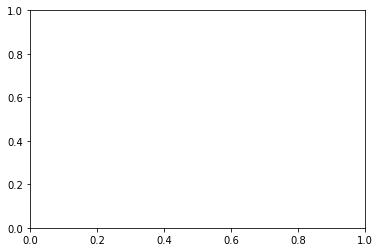

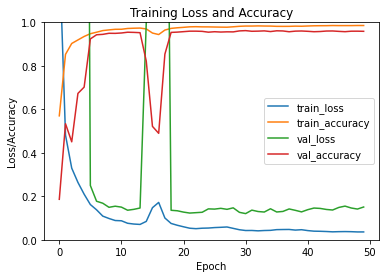

In [45]:
model.train(
    train_images =  "/kaggle/input/football-seg-v3/train_img/",
    train_annotations = "/kaggle/input/football-seg-v3/train_label/",
    #checkpoints_path = "/kaggle/input/football-seg-v3/checkpoints/pspnet_101_finetune_dataset2/pspnet_101_finetune_dataset2" ,
    epochs=50,
    validate=True,
    val_images='/kaggle/input/football-seg-v3/val_img/',
    val_annotations='/kaggle/input/football-seg-v3/val_label/',
    batch_size = 2,
    steps_per_epoch = 40, # 40
    val_steps_per_epoch = 40, # 40
    callbacks = cbs,
)

In [46]:
def show_multi_imgs(scale, imglist, order=None, border=10, border_color=(255, 255, 0)):
    """
    :param scale: float 原图缩放的尺度
    :param imglist: list 待显示的图像序列
    :param order: list or tuple 显示顺序 行×列
    :param border: int 图像间隔距离
    :param border_color: tuple 间隔区域颜色
    :return: 返回拼接好的numpy数组
    """
    if order is None:
        order = [1, len(imglist)]
    allimgs = imglist.copy()
    ws , hs = [], []
    for i, img in enumerate(allimgs):
        if np.ndim(img) == 2:
            allimgs[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        allimgs[i] = cv2.resize(img, dsize=(0, 0), fx=scale, fy=scale)
        ws.append(allimgs[i].shape[1])
        hs.append(allimgs[i].shape[0])
    w = max(ws)
    h = max(hs)
    # 将待显示图片拼接起来
    sub = int(order[0] * order[1] - len(imglist))
    # 判断输入的显示格式与待显示图像数量的大小关系
    if sub > 0:
        for s in range(sub):
            allimgs.append(np.zeros_like(allimgs[0]))
    elif sub < 0:
        allimgs = allimgs[:sub]
    imgblank = np.zeros(((h+border) * order[0], (w+border) * order[1], 3)) + border_color
    imgblank = imgblank.astype(np.uint8)
    for i in range(order[0]):
        for j in range(order[1]):
            imgblank[(i * h + i*border):((i + 1) * h+i*border), (j * w + j*border):((j + 1) * w + j*border), :] = allimgs[i * order[1] + j]
    return imgblank

In [47]:
val_img_path = '/kaggle/input/football-seg-v3/val_img/*'
val_img_list = glob.glob(val_img_path)
val_img_list.sort()

val_result = []
for i in range(len(val_img_list)):
    out = model.predict_maps( inp=val_img_list[i] )
    # print('out.shape',out.shape)
    # cv2.imshow(str(i), out)
    # cv2.waitKey(0)
#     out = out[:, :, (2, 1, 0)] # cv2的BGR->plt的RGB
    val_result.append(out)

True

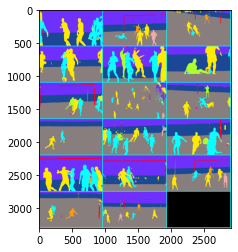

In [48]:
# show_and_save_maps(val_result)
img = show_multi_imgs(0.5, val_result, (6,3))
plt.imshow(img[:, :, (2, 1, 0)])
#cv2.namedWindow('val_result_multi', 0)
#cv2.imshow('val_result_multi', img)

cv2.imwrite('000_val_result_multi.png', img)

In [49]:
# evaluate IoU, fIoU...
eval_result = model.evaluate_segmentation( inp_images_dir="/kaggle/input/football-seg-v3/val_img/"  , 
    annotations_dir="/kaggle/input/football-seg-v3/val_label/" ) 

17it [00:07,  2.39it/s]


In [50]:
eval_result

{'frequency_weighted_IU': 0.9226113359048862,
 'mean_IU': 0.6831814724965624,
 'class_wise_IU': array([0.        , 0.64242763, 0.78625223, 0.79673455, 0.81793566,
        0.77576739, 0.25856004, 0.60369087, 0.94449154, 0.92474507,
        0.96439123]),
 'class_wise_pixels_norm': array([7.65743690e-06, 4.86607593e-03, 1.12809811e-02, 6.39046892e-02,
        6.05914965e-02, 3.52467316e-03, 1.80940730e-03, 1.47961951e-02,
        2.39375081e-01, 1.65608964e-01, 4.34234779e-01])}

In [51]:
def number2string_format(inp):
    # 保留4位小数点（四舍五入）：round(l[i], 4)
    # 小数点未满4位的填补0："{:.4f}".format()
    return str("{:.4f}".format(round(inp, 4)))

def list2string(lis):
    # 输入一个list，输出一行string，list的每个数字保留4位小数，数字之间用空格隔开
    s = ''
    for i in range(len(lis)):
        s += number2string_format(lis[i])
        s += ' '
    return s

def write2txt(loss, eval_result, filename):
    file = open(filename, "w")
    i = 0

    # 先把eval_result写入
    for value in eval_result.values():
        if i < 2 : # frequency_weighted_IU, mean_IU
            value_format = number2string_format(value)
        else: # class_wise_IU, class_wise_pixels_norm
            value_format= list2string(value)
        file.write(value_format)
        file.write('\n')
        i += 1

    # 再把loss写入
    for value in loss.values():
        value_format= list2string(value)
        file.write(value_format)
        file.write('\n')

    file.close()

In [52]:
loss_dict = {'train_losses': trainplot.losses,
            'train_acc': trainplot.acc,
            'val_losses': trainplot.val_losses,
            'val_acc':trainplot.val_acc}

# save to txt
write2txt(loss_dict,eval_result, "000_eval.txt")

In [60]:
from IPython.display import FileLink
FileLink('000_weight.h5')

/kaggle/working/000_weight.h5

In [59]:
FileLink('000_eval.txt')

/kaggle/working/000_val_result_multi.png

In [ ]:
FileLink('000_log.png')

In [ ]:
FileLink('000_val_result_multi.png')